# Regression Analysis of Inflation and Key Economic Data

## Goal 
In this project, we are going to establish if there are any relationship between inflation and core economic indicators: 
* GDP growth (output),
* unemployment rate,
* interest rate. 

## Model
The initial idea was to build a multiple regression model with four perameters. However, after the closer examination, it turns out that the GDP and PCE variables are not significant. Thus, the final representation of the model does not contain these variables. Therefore, the model looks like this:

\begin{equation}
R_{inf} = \beta_0 + \beta_1R_{unemployment} + \beta_2R_{interest} + \epsilon,
\end{equation}

where 
* $R_{inf}$ -- the inflation rate,
* $R_{unemployment}$ -- the unemployment rate,
* $R_{interest}$ -- the interest rate,
* $\epsilon$ -- random component.

## OLS Regression Assumptions

1. The relationship between the dependent and independent variables is linear;
2. Full Rank, i.e. there is no multicollinearity between the independent variables; 
3. Exogeneity of the independent variables: $E[\epsilon_i | x_{j1}, x_{xj2},...,x{jk}]=0$;
4. There is no correlation between independent variables and the residuals;
5. Homoscedasticity and nonautocorrelation of the residuals;
6. Residuals are normally distributed; 

## Specification
Location:
* The US Market;

Time Horizon:
* 31 years (1992-01-01, 2023-04-01);

Frequency:
* Monthly;

## Data Sources
* CPI Data: https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL
* Unemployment Data: https://fred.stlouisfed.org/series/UNRATE
* FED's Fund Rate Data: https://fred.stlouisfed.org/series/DFF
* Personal Consumption Expenditures: https://fred.stlouisfed.org/series/PCE
* GDP Data: https://www.spglobal.com/marketintelligence/en/mi/products/us-monthly-gdp-index.html

## Results

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Loading data
data = pd.read_csv('data/multiple_regression_data.csv', parse_dates=['date'])
data = data.set_index('date')

In [3]:
#Calculations
data.feds_fund_rate = data.feds_fund_rate / 100
data.unemployment_rate = data.unemployment_rate / 100
data.core_cpi = data.core_cpi / 100
data.pce = data.pce.pct_change(12)
data.nominal_gdp = data.nominal_gdp.pct_change(12)
data = data.dropna()

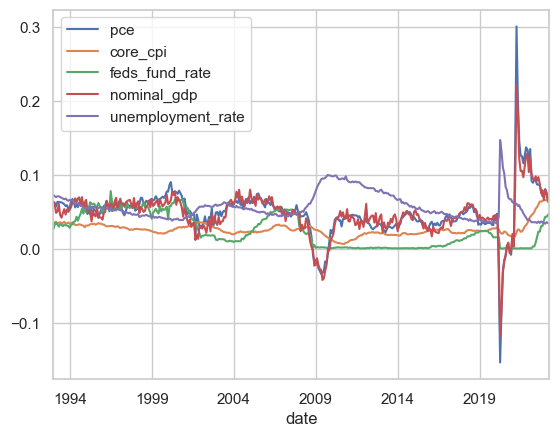

In [4]:
#Plotting curves
sns.set_theme(style='whitegrid')
data.plot()
plt.show()

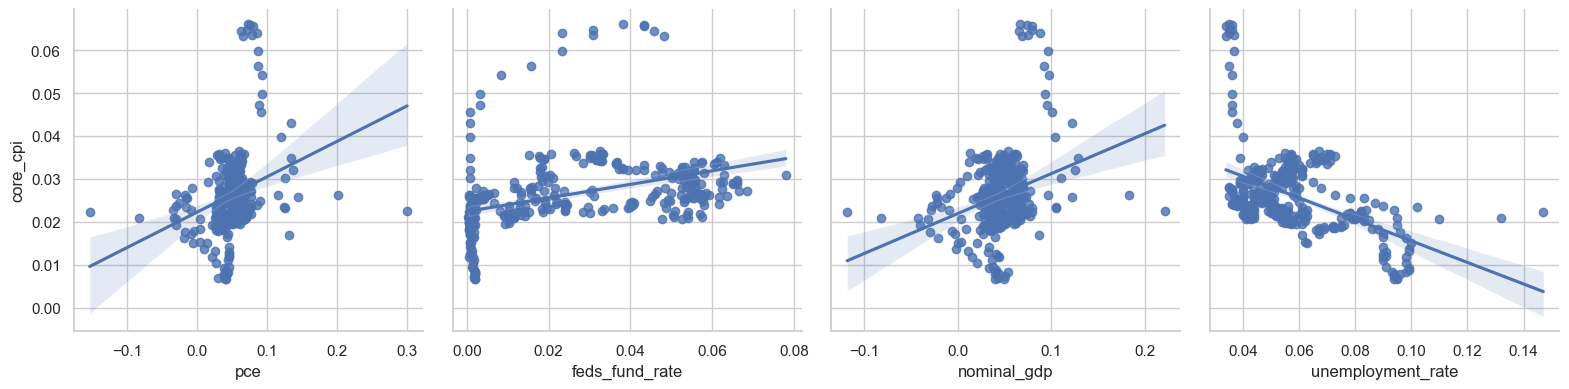

In [5]:
#plotting scatter plot with a regression line
sns.set(style='whitegrid')
g = sns.PairGrid(data, y_vars=['core_cpi'], x_vars=data.columns.drop('core_cpi'), height=4)
g.map(sns.regplot)
plt.show()

In [6]:
#estimating correlation matrix
print('Correlation Matrix:')
print(data.corr())

Correlation Matrix:
                        pce  core_cpi  feds_fund_rate  nominal_gdp  \
pce                1.000000  0.291559        0.277620     0.950313   
core_cpi           0.291559  1.000000        0.387295     0.298224   
feds_fund_rate     0.277620  0.387295        1.000000     0.280209   
nominal_gdp        0.950313  0.298224        0.280209     1.000000   
unemployment_rate -0.513276 -0.491170       -0.497045    -0.531049   

                   unemployment_rate  
pce                        -0.513276  
core_cpi                   -0.491170  
feds_fund_rate             -0.497045  
nominal_gdp                -0.531049  
unemployment_rate           1.000000  


In [7]:
#Building OLS regression model
x = sm.add_constant(data[data.columns.drop(['core_cpi', 'nominal_gdp', 'pce'])])
y = data.core_cpi
model = sm.OLS(y, x)
fitted_model = model.fit()

#Displaying results
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:               core_cpi   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     66.24
Date:                Sat, 01 Feb 2025   Prob (F-statistic):           3.12e-25
Time:                        15:14:53   Log-Likelihood:                 1250.4
No. Observations:                 364   AIC:                            -2495.
Df Residuals:                     361   BIC:                            -2483.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0360      0.00

In [8]:
# Estimating VIF for independent variables
print('Variance Inflation Factor (VIF):')
print(f'feds_fund_rate: {variance_inflation_factor(x.values, 1):.2f}')
print(f'unemployment_rate: {variance_inflation_factor(x.values, 2):.2f}')

Variance Inflation Factor (VIF):
feds_fund_rate: 1.33
unemployment_rate: 1.33


## Discussion

* The correlation matrices and regression plots indicate that the variables $gdp$ and $pce$ are highly correlated with each other, but they do not show any significant correlation with the dependent variable. Moreover, there is no clear linear relationship between these variables and the dependent variable. Therefore, we will exclude them from the model.

* On the other hand, the other variables show more promising results, aligning with common economic theory and the economic policy of the FED, which aims to maintain price stability, maximum employment, and economic growth. Typically, central banks use interest rates as the primary tool to control inflation. In the medium run, the unemployment rate is assumed to negatively influence inflation through consumption which is backed up by the correlation matrix. Also, according to the Keynesian school of thought, the employment level in an economy heavily depends on the aggregate investment level, which, in turn, relies on interest rates and investing capital yields. Consequently, a rise in interest rates may lead to a fall in investment, potentially resulting in reduced employment levels. Thus, we need to be cautious about potential multicollinearity issues.

* To start, we run a simple regression without addressing the multicollinearity problem. All independent variables are statistically significant, supported by both the F-statistic and individual t-tests. However, the model explains only around $27\%$ of the variability in the data, which is relatively low. Additionally, the distribution of errors is non-normal, as confirmed by both Omnibus and JB tests. The distribution is positively skewed with fat tails, indicating that large errors are common, leading the model to underestimate inflation rates. Fortunately, the Durbin-Watson test suggests that the residuals are not autocorrelated, and the conditional number is low, implying that the model is not highly sensitive to changes.

* Now, let's delve into the concept of multicollinearity, as it can significantly impact the accuracy and interpretability of our model. Addressing multicollinearity is crucial to establish a meaningful relationship between the independent variables and the dependent variable. To assess the strength of collinearity in our case, we can utilize the Variance Inflation Factor (VIF), a common tool in such situations. The VIF measures the extent of correlation between independent variables by regressing each variable against the others and calculating the VIF for each of them using the formula $1/(1-R^2_i)$, where $R^2_i$ is the coefficient of determination. A VIF value of 1 indicates perfect independence, which is ideal. In our analysis, we find that the variables have VIFs close to 1, suggesting relatively low multicollinearity. Nonetheless, it is important to be vigilant. If the VIFs were considerably larger than 1, it would signal a more pronounced multicollinearity issue. In such cases, we would need to consider alternative approaches, like combining variables or selecting a different model to effectively address the multicollinearity problem. However, for our current scenario, the VIFs being close to 1 indicate that we can proceed with the existing model without major concerns about multicollinearity.

## Conclusion 
The data reveals statistically significant positive relationships between the FED's fund rate and the inflation rate, as well as a statistically significant negative relationship between the unemployment rate and the inflation rate. These findings are consistent with well-established economic theory.

According to this theory, inflation triggers a reaction from the FED, which is manifested through interest rate hikes. These interest rate hikes, in turn, lead to a reduction in aggregate investments and an increase in unemployment. The rise in unemployment helps alleviate inflationary pressures in the short run. This dynamic relationship between the variables highlights the intricate interplay between monetary policy, inflation, and the labor market in the economy.